In [47]:
import torch
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [48]:
import torch.nn as nn
liner_model = nn.Linear(1, 1)
liner_model(t_un_val)

tensor([[-1.7338],
        [-0.4710]], grad_fn=<AddmmBackward0>)

In [49]:
liner_model.weight, liner_model.bias

(Parameter containing:
 tensor([[-0.3272]], requires_grad=True),
 Parameter containing:
 tensor([0.2422], requires_grad=True))

In [50]:
x = torch.ones(10, 1)
liner_model(x)

tensor([[-0.0849],
        [-0.0849],
        [-0.0849],
        [-0.0849],
        [-0.0849],
        [-0.0849],
        [-0.0849],
        [-0.0849],
        [-0.0849],
        [-0.0849]], grad_fn=<AddmmBackward0>)

In [51]:
import torch.optim as optim
optimizer = optim.SGD(liner_model.parameters(), lr=1e-2)

In [70]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
            
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=liner_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)
liner_model.weight, liner_model.bias

Epoch 1, Training loss 2.5461, Validation loss 5.7390
Epoch 1000, Training loss 2.5461, Validation loss 5.7390
Epoch 2000, Training loss 2.5461, Validation loss 5.7390
Epoch 3000, Training loss 2.5461, Validation loss 5.7390


(Parameter containing:
 tensor([[5.6454]], requires_grad=True),
 Parameter containing:
 tensor([-18.7224], requires_grad=True))

In [71]:
# neural network
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [72]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [87]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

print(seq_model)

for name, param in seq_model.named_parameters():
    print(name, param.shape)

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)
hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [88]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0884], requires_grad=True)

In [89]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

Epoch 1, Training loss 203.1308, Validation loss 90.5995
Epoch 1000, Training loss 4.8066, Validation loss 3.8598
Epoch 2000, Training loss 3.4741, Validation loss 1.3507
Epoch 3000, Training loss 2.1486, Validation loss 3.6305
Epoch 4000, Training loss 1.8776, Validation loss 4.9875
Epoch 5000, Training loss 1.7110, Validation loss 6.1593


In [90]:
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

output tensor([[16.5407],
        [-1.1095]], grad_fn=<AddmmBackward0>)
answer tensor([[13.],
        [-4.]])
hidden tensor([[ -0.0262],
        [-16.1597],
        [ 15.6206],
        [-16.0165],
        [ -0.1746],
        [  0.2398],
        [  0.0939],
        [-16.9992]])


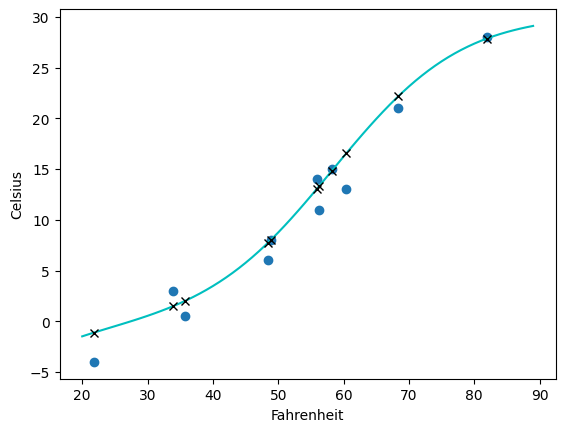

In [91]:
import matplotlib.pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')